# System Identification for Segway System

The first thing to be done is load all libraries that will be used.  Sympy provides symbolic algebra functionality, matplotlib enables plotting functions, and pylab, numpy, and scipy are additionaly math libraries that help us do the system identification.

In [61]:
import sympy
import sympy.physics.mechanics as mech
sympy.init_printing(use_latex='mathjax')
from IPython.display import display
%matplotlib inline
%load_ext autoreload
%autoreload 2
import px4_logutil
import pylab as pl
from px4_logutil import savitzky_golay
import numpy as np
import scipy.integrate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define BKE Function

In [62]:
def bke(vector, frame_i, frame_b, t):
    return (vector.diff(t, frame_b) + frame_b.ang_vel_in(frame_i).cross(vector))

### Define Symbolic Variables

In [63]:
T, r, m_w, m_p, l, F, x, g, alpha, theta, t, R_x, R_z, N, J_p, J_w, v_x, omega, k_emf, b_damp, V, J_motor, a = \
    sympy.symbols('T r m_w m_p l F x g alpha theta t R_x R_z N J_p J_w v_x omega k_emf b_damp V J_motor a')

# Dynamics

The first thing we will do to get started  is to show the equations of motion for the segway system.  These equations are derived here using the Newton-Euler method.  Essentially the process involves using a force and moment balance, along with constraint equations, to produce a system of equations with unknowns that we can then solve for.  Two of the unknown variables we would like to solve for are $\theta$ and $x$, which are the pitch angle and position of the segway.  These are the two most important variables because knowing how they change allows us to then make the segway stable and movable.

### Define Reference Frames

In [64]:
frame_i = mech.ReferenceFrame('i') #inertial frame
frame_b = frame_i.orientnew('b', 'Axis', [theta(t), frame_i.y]) #fixed in pendulum
frame_w = frame_b.orientnew('w', 'Axis', [-alpha(t), frame_i.y]) #fixed in wheel

### Define Points of Interest

In [65]:
point_o = mech.Point('o') 
point_o.set_vel(frame_i, 0) #point o is inertially fixed

point_W = point_o.locatenew('W', frame_i.x*x(t))  #wheel c.m.
point_W.set_vel(frame_b, 0) #point W is fixed in pendulum frame, too
point_W.set_vel(frame_i, point_W.pos_from(point_o).diff(t, frame_i))

point_P = point_W.locatenew('P', frame_b.z*(-l)) #pendulum c.m.
point_P.set_vel(frame_b, 0)
point_P.v2pt_theory(point_W, frame_i, frame_b);

### Creation of the Bodies (Wheel and Pendulum)

In [66]:
# Wheel Creation
J_wheel = mech.inertia(frame_w, 0, J_w, 0)
wheel = mech.RigidBody('wheel', point_W, frame_w, m_w, (J_wheel, point_W))

# Pendulum Creation
J_pend = mech.inertia(frame_b, 0, J_p, 0)
pend = mech.RigidBody('pend', point_P, frame_b, m_p, (J_pend, point_P)) #change inertia point to point_p

### Pendulum Dynamics

In [67]:
# Pendulum F=ma equation of motion
eom_pend_Newt = bke(pend.linear_momentum(frame_i), frame_i, frame_b, t) \
    - (R_x(t)*frame_i.x) \
    - (-R_z(t)*frame_i.z + m_p*g*frame_i.z)
eom_pend_Newt = eom_pend_Newt.simplify()

#Pendulum Euler's Law
eom_pend_Euler = bke(pend.angular_momentum(point_P, frame_i), frame_i, frame_b, t) \
    - R_x(t)*sympy.cos(theta(t))*(l)*frame_b.y \
    - R_z(t)*sympy.sin(theta(t))*(l)*frame_b.y - (T(t)*frame_b.y)
    

### Wheel Dynamics

In [68]:
# Wheel F=ma equation of motion, with reaction force at pin included
eom_wheel_Newt = wheel.linear_momentum(frame_i).diff(t, frame_i) \
    - (F(t)*frame_i.x) - (-R_x(t)*frame_i.x) \
    - R_z(t)*frame_i.z - (-N(t)*frame_i.z) - m_w*g*frame_i.z
    
#Wheel Euler's Law
eom_wheel_Euler = bke(wheel.angular_momentum(point_W, frame_i), frame_i, frame_w, t) \
    - (-T(t)*frame_w.y) - (F(t)*r*frame_w.y)

### Motor Dynamics

The dynamics of the motor is given by the equation below.  $V(t)$ is the voltage supplied to the motor, and $k_{emf}$ is the gain constant that relates the voltage supplied to the torque produced.  Note that this value is not known ahead of time.  Additionally, note the assumption that the relationship between voltage and torque is linear.

In [69]:
eom_motor = T(t) + k_emf*V(t) - b_damp*alpha(t).diff(t) - J_motor*alpha(t).diff(t,2)

### Constraint Equation (No Slip of Wheels)

In [70]:
no_slip = r*(alpha(t) - theta(t)) - x(t)

# Solving For The EOM's

Take all of the equations of motion and solve them for the variables we need.  

In [71]:
eoms = sympy.Matrix([eom_pend_Newt.dot(frame_i.x), eom_wheel_Newt.dot(frame_i.x), #in the x direction
    eom_pend_Euler.dot(frame_i.y), eom_wheel_Euler.dot(frame_i.y), #in the y direction (moments)
    eom_pend_Newt.dot(frame_i.z), eom_wheel_Newt.dot(frame_i.z), #in the z direction
    eom_motor, #the equation of motion for the motor
    no_slip,
    no_slip.diff(t),
    no_slip.diff(t,2)]) #the constraint equation

In [72]:
eom_sol = sympy.solve(eoms, [T(t), N(t), R_x(t), R_z(t), F(t), theta(t).diff(t,2), \
        alpha(t).diff(t,2), x(t).diff(t,2), alpha(t).diff(t), alpha(t)], simplify=False)

Now we have solved for each of the unknown variables in terms of system properties and theta,
the next step is to look specifically at the variables of most importance, $\ddot{x}$ and $\ddot{\theta}$

In [73]:
theta_ddot = eom_sol[theta(t).diff(t,2)].expand().ratsimp().collect([theta(t), x(t), V(t), theta(t).diff(t), x(t).diff(t)], sympy.factor)
theta_ddot

                                                                              
              ⎛                               2        2⎞ d                 ⎛ 
     b_damp⋅r⋅⎝J_w + l⋅m_p⋅r⋅cos(θ(t)) + m_p⋅r  + m_w⋅r ⎠⋅──(θ(t)) + b_damp⋅⎝J
                                                          dt                  
──────────────────────────────────────────────────────────────────────────────
  ⎛                                      2        2                  2        
r⋅⎝-J_motor⋅J_p - J_motor⋅J_w - J_motor⋅l ⋅m_p⋅sin (θ(t)) - J_motor⋅l ⋅m_p⋅cos

                                                                              
                              2        2⎞ d                    ⎛              
_w + l⋅m_p⋅r⋅cos(θ(t)) + m_p⋅r  + m_w⋅r ⎠⋅──(x(t)) + g⋅l⋅m_p⋅r⋅⎝-J_motor + J_w
                                          dt                                  
──────────────────────────────────────────────────────────────────────────────
2                                                  

In [74]:
x_ddot = eom_sol[x(t).diff(t,2)].expand().ratsimp().collect([theta(t), x(t), V(t), theta(t).diff(t), x(t).diff(t)], sympy.factor)
x_ddot

                                                                              
         ⎛       2        2          2        2                          ⎞ d  
b_damp⋅r⋅⎝J_p + l ⋅m_p⋅sin (θ(t)) + l ⋅m_p⋅cos (θ(t)) + l⋅m_p⋅r⋅cos(θ(t))⎠⋅──(
                                                                           dt 
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                         -J_motor⋅J_p - J_motor⋅J_w - J_motor⋅

                                                                              
               ⎛       2        2          2        2                         
θ(t)) + b_damp⋅⎝J_p + l ⋅m_p⋅sin (θ(t)) + l ⋅m_p⋅cos (θ(t)) + l⋅m_p⋅r⋅cos(θ(t)
                                                                              
──────────────────────────────────────────────────────────────────────────────
 2        2                  2        2            

Obviously these equations shown above are quite complicated.  It would be very difficult to use these forms of the equations of motion for our system identification analysis, because the unknown parameters are not isolated.  Luckily, for the experiments that we will be performing, the equations of motion are much more simple.  For example, we will clamp the wheels to a stationary fixture and let the body of the segway swing like a pendulum.  This allows us to simplify the dynamics to forms that we can much more easily handle.  This is shown below for each experiment run:

1. Pendulum Dynamics Only
2. Motor Dynamics Only

# System Identification - Pendulum

Two system identification experiments were performed.  The first is looking at the dynamics of just the pendulum.  The pendulum was secured by the wheels to be hanging, and the experiment consisted of letting the pendulum swing from an initial position until the oscillation damped out.  To begin the analysis of the pendulum unknown parameters we need to look at the pendulum equations of motion.  These equations build from the dynamics that were defined at the beginning of this notebook.

In [75]:
eom_pend_Euler #pendulum rotational equation of motion (Euler's Law) M=Hdot

⎛      2                                                      ⎞
⎜     d                                                       ⎟
⎜J_p⋅───(θ(t)) - l⋅Rₓ(t)⋅cos(θ(t)) - l⋅R_z(t)⋅sin(θ(t)) - T(t)⎟
⎜      2                                                      ⎟
⎝    dt                                                       ⎠ b_y

In [76]:
eom_pend_Newt #pendulum linear equation of motion (Newton's Law) F=ma

⎛      2              ⎞
⎜     d               ⎟
⎜m_p⋅───(x(t)) - Rₓ(t)⎟
⎜      2              ⎟
⎝    dt               ⎠ i_x + (-g⋅m_p + R_z(t)) i_z +          2      
        d       
-l⋅m_p⋅───(θ(t))
         2      
       dt        b_x +                 2
      ⎛d       ⎞ 
l⋅m_p⋅⎜──(θ(t))⎟ 
      ⎝dt      ⎠  b_z

In [77]:
pend_sysID_const = theta(t) + alpha(t) #define a constraint that theta is equal to -alpha
pend_sysID_const

α(t) + θ(t)

Now we need to solve 

In [180]:
sol_pend_sysID = sympy.solve(
    [pend_sysID_const, pend_sysID_const.diff(t), pend_sysID_const.diff(t, 2)] + #constraint eq, & derivatives
    list(eom_pend_Newt.to_matrix(frame_i)) + #linear eom
    list(eom_pend_Euler.to_matrix(frame_i)) + [eom_motor], #rotational eom 
    [R_x(t), R_z(t), theta(t).diff(t,2), T(t), alpha(t).diff(t, 2), alpha(t).diff(t)]) #variables to solve for

Now we have solutions for each of the variables, let's take a look at the solution of the second derivative of theta [theta(t).diff(t, 2)].

In [81]:
pend_sysID = (sol_pend_sysID[theta(t).diff(t,2)].subs({x(t).diff(t,2):0, V(t):0}) - theta(t).diff(t,2))
pend_sysID

         d                                       
- b_damp⋅──(θ(t)) + g⋅l⋅m_p⋅sin(θ(t))     2      
         dt                              d       
───────────────────────────────────── - ───(θ(t))
                         2                2      
        J_motor + J_p + l ⋅m_p          dt       

Note the format of the equation above, it is expected because you have a damping term multiplied by the angular velocity, the gravity torque term, and you have the mass properties about the pivot point, consisting of the moment of inertia of the motor plus the moment of inertia of the pendulum about the pivot point using the parallel axis theorem ($J_p$ is the moment of inertia of the pendulum ABOUT THE C.M.)

Let's take a look at the data we collected during the experiment.  We open the file from the log that the PixHawk takes, it contains data from all sensors that the PixHawk has.  We will look at a couple that are of interest to us.

In [82]:
with open('data/segway/pend_sysid/sess126/log001.csv', 'r') as loadfile:
    pend_data2 = px4_logutil.px4_log_to_namedtuple(loadfile)

In the function below that prepares the log data for analysis, there is a call to a function called savitzky_golay.  This is a filter type that smoothes the discrete time data collected in the log.  It is primarily used here to also take a numerical derivative.  The theory can be seen here:

en.wikipedia.org/wiki/Savitsky-Golay_filter

The function call requires parameters shown below:

function in px4_logutil "def savitzky_golay(y, window_size, order, deriv=0, rate=1):"

In [83]:
mass = 2.243 #kg
l = 0.3175 #meters
g = 9.81 #m/s^2

In [84]:
def handle_log_data_pend(data, i_start, i_end): #define a function that manipulates data for sys ID use
    t = (data.TIME.StartTime[i_start:i_end] - data.TIME.StartTime[i_start])/1e6 # [s]
    dt = savitzky_golay(t, 21, 1, 1) #derivative of discrete time array
    theta = data.ATT.Pitch[i_start:i_end] #pitch angle [rad]
    thetadot = data.ATT.PitchRate[i_start:i_end] #pitch rate [rad/s]
    thetaddot = savitzky_golay(thetadot, 21, 1, 1)/dt #pitch angular acc [rad/s^2]
    torque = mass*g*l*np.sin(theta) #torque due to gravity
    return px4_logutil.dict_to_namedtuple('data', locals())

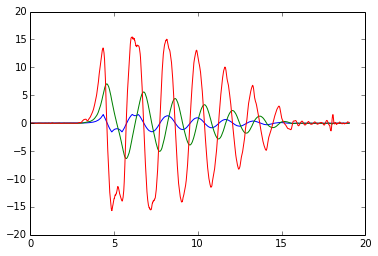

In [85]:
data = handle_log_data_pend(pend_data2, 1, -1)
pl.plot(data.t, data.theta)
pl.plot(data.t, data.thetadot)
pl.plot(data.t, data.thetaddot)

We can see that there are some weird parts of the data from the first oscillation, experimental setup error most likely.  We can cut this off by playing with the starting and ending indicies

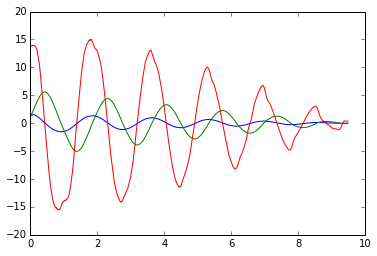

In [86]:
data = handle_log_data_pend(pend_data2, 1000, 2500)
pl.plot(data.t, data.theta)
pl.plot(data.t, data.thetadot)
pl.plot(data.t, data.thetaddot)

This looks much better. We can put the plotting commands into functions now so that we don't have to continue creating a thousand lines of commands each time we want to plot.

In [87]:
def plot_theta(data):
    pl.plot(data.t, pl.rad2deg(data.theta))
    pl.xlabel('Time (s)')
    pl.ylabel(r'${\theta}$, (deg)')
    return
    
def plot_thetadot(data):
    pl.plot(data.t, pl.rad2deg(data.thetadot))
    pl.xlabel('Time (s)')
    pl.ylabel(r'$\dot\dot{\theta}$, (deg/s)')
    return

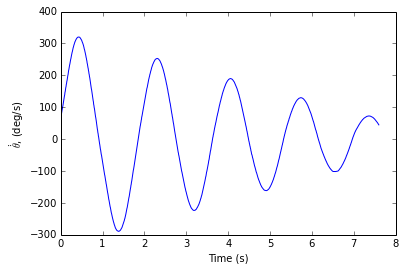

In [88]:
trial2 = handle_log_data_pend(pend_data2, 1000, 2200)
plot_thetadot(trial2)

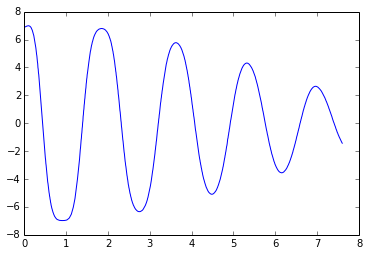

In [89]:
pl.plot(trial2.t, trial2.torque)

Now that we have shown the data, we want to perform the actual system identification.  From the equation "pend_sysID" shown below, we can predict how the system SHOULD perform.  The equation can then be fit to the data using a least squares approach.  This fit will tell us the values of the unknown parameters of our equation.

## Least Squares Analysis 

In [90]:
A = np.vstack((trial2.thetadot, trial2.thetaddot)).T #now column 1 is thetadot, column 2 is thetaddot
b = trial2.torque
b_damp, J_total = np.dot(pl.pinv(A), b) #x = A+ dot b (solution to Ax=b)
b_damp, J_total

(0.124919434429, 0.471701482974)

Recall that the equation we used for the least squares analysis was the motion of the rigid body pendulum with damping, given by:

$J_{total}\ddot{\theta} + b_{damp}\dot{\theta} - m_p g l sin({\theta}) = 0$

but this differs slightly from the derived equation of motion for our system (from before)

$(J_{motors} + J_p + m_p l^2)\ddot{\theta} + b_{damp}\dot{\theta} - m_p g l sin({\theta}) = 0$

This is an important aspect of system identification.  We were able to identify the parameters $b_{damp}$ and $J_{total}$,  but we can't seperate out $J_p$ and $J_{motors}$ individually.  

##Simulation and Validation

We have a linear second order differential equation that describes the motion of the pendulum.  We will now solve this numerically using the estimated parameter values that were just determined, then we can see how well the estimation worked.  To perform the simulation we just build a function that describes the equation of motion, and then use an ode solver from the numpy module.

In [91]:
def pend_eom(t, x, m, g, l, J_total, b_damp): #x is a vector of states [theta; thetadot]
    theta = x[0]
    theta_dot = x[1]
    rhs = (m*g*l*np.sin(theta))/J_total - (b_damp*theta_dot)/J_total #rhs of the equation of motion for theta
    return [theta_dot, rhs]

In [92]:
def simulate(b_damp, J_total, data, plot):
    sim = scipy.integrate.ode(pend_eom) #setup for ode intergration
    sim.set_initial_value(y = [ data.theta[0], data.thetadot[0] ], t = data.t[0]) #set initial values
    sim.set_f_params(mass, g, l, J_total, b_damp) #pass other variables in the integration
    i = 0
    x = np.zeros((len(data.t), 2)) #define array to hold calculated values from integration
    x[0,:] = sim.y
    for i in range(1,len(data.t)): #step through time vector and integrate the states
        sim.integrate(data.t[i])
        x[i,:] = sim.y
    thetadot_sim = x[:,1]
    if plot: #plot the results against the expected
        pl.plot(data.t, pl.rad2deg(data.thetadot))
        pl.plot(data.t, pl.rad2deg(x[:,1]))
        pl.xlabel('Time (s)')
        pl.ylabel(r'$\dot\dot{\theta}$, (deg/s)')
        pl.legend(['Experimental','Simulated'])
    return thetadot_sim

In [93]:
def R_squared(f, y): #f = modeled values:  y = data values
    r = y - f #residual
    t = y - y.mean(0)
    tot_sum_squares = t.dot(t.T) #total sum of squares
    resid_sum_squares = r.dot(r.T) #residual sum of squares
    R_sq = 1 - resid_sum_squares/tot_sum_squares
    return R_sq

###Trial 1 Data Validation 

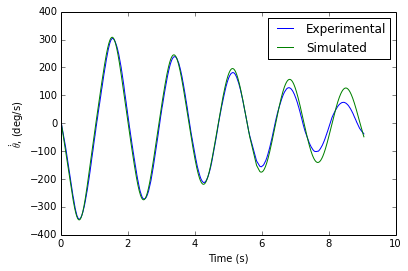

In [94]:
with open('data/segway/pend_sysid/sess125/log001.csv', 'r') as loadfile:
    pend_data1 = px4_logutil.px4_log_to_namedtuple(loadfile)

trial1 = handle_log_data_pend(pend_data1, 800, 2200) #sess 125
thetadot_sim1 = simulate(b_damp, J_total, trial1, True)

In [95]:
#R_squared(trial1.thetadot, thetadot_sim1)
R_squared(J_total*trial1.thetaddot + b_damp*trial1.thetadot, trial1.torque) #calculate R^2

0.990204770677

###Trial 2 Data Validation 

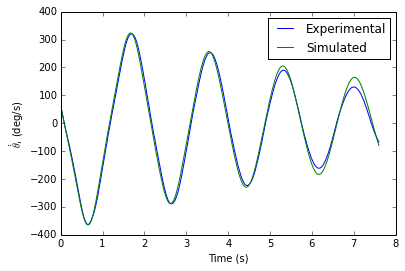

In [96]:
with open('data/segway/pend_sysid/sess126/log001.csv', 'r') as loadfile:
    pend_data2 = px4_logutil.px4_log_to_namedtuple(loadfile)

trial2 = handle_log_data_pend(pend_data2, 800, 2000) #session 127
thetadot_sim2 = simulate(b_damp, J_total, trial2, True)

In [97]:
R_squared(J_total*trial2.thetaddot + b_damp*trial2.thetadot, trial2.torque) #calculate R^2

0.993303567269

### Trial 3 Data Validation 

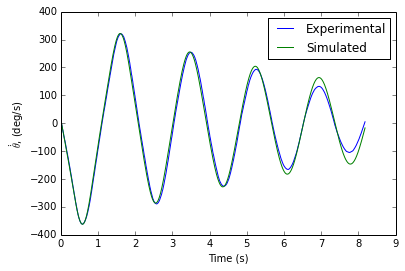

In [98]:
with open('data/segway/pend_sysid/sess127/log001.csv', 'r') as loadfile:
    pend_data3 = px4_logutil.px4_log_to_namedtuple(loadfile)

trial3 = handle_log_data_pend(pend_data3, 1400, 2700) #session 127
thetadot_sim3 = simulate(b_damp, J_total, trial3, True)

In [99]:
R_squared(J_total*trial3.thetaddot + b_damp*trial3.thetadot, trial3.torque) #calculate R^2

0.993723524559

# System Identification - Motor Experiment

The second experiment conducted simply looks at the motor performance.  The segway is held steady at an arbitrary angle, which allows the controller to spin the motors when the throttle is activated (it will try to steady itself by applying a torque).

In [100]:
eom_motor

            2                                            
           d                 d                           
- J_motor⋅───(α(t)) - b_damp⋅──(α(t)) + k_emf⋅V(t) + T(t)
            2                dt                          
          dt                                             

In [101]:
motor_sysID = eom_motor.subs({T(t):0}) #no external torque is being applied
motor_sysID

            2                                     
           d                 d                    
- J_motor⋅───(α(t)) - b_damp⋅──(α(t)) + k_emf⋅V(t)
            2                dt                   
          dt                                      

The equations of motion for the motor is shown above.  For system identification purposes, this equation is rearranged in the following form:

$\ddot{\alpha} + \frac{b_{damp}}{J_{motor}} \dot{\alpha} - \frac{k_{emf}}{J_{motor}} V = 0$

Note that in this case, the parameters that we can identify are $\frac{b_{damp}}{J_{motor}}$ and $\frac{k_{emf}}{J_{motor}}$,  but we can't seperate out the individual parameter values. 

Now that we have the equation of motion that describes the dynamics of the system, we can analyze the test data and perform a least squares prediction of the parameters.  These methods are essentially the same as from the pendulum system identification.

In [102]:
def handle_log_data_motors(data, i_start, i_end): #define a function that manipulates data for sys ID use
    t = (data.TIME.StartTime[i_start:i_end] - data.TIME.StartTime[i_start])/1e6 # [s]
    dt = savitzky_golay(t, 21, 1, 1) #derivative of discrete time array
    
    alpha0 = data.ENCD.cnt0[i_start:i_end]*2*np.pi/3200 #motor 0 shaft angle [rad]
    alpha1 = data.ENCD.cnt1[i_start:i_end]*2*np.pi/3200 #motor 1 shaft angle [rad]
    alpha = (alpha0 + alpha1)/2 #take the average of both motors
    
    alpha0dot = data.ENCD.vel0[i_start:i_end]*2*np.pi/3200 #motor 0 shaft angular velocity [rad/s]
    alpha1dot = data.ENCD.vel1[i_start:i_end]*2*np.pi/3200 #motor 1 shaft angular velocity [rad/s]
    alphadot = (alpha0dot + alpha1dot)/2 #take the average of both motors
    alphadot = savitzky_golay(alphadot, 13, 1) #smooth the data a bit
    
    alphaddot = savitzky_golay(alphadot, 13, 1, 1)/dt

    #Battery stuff
    voltage = data.BATT.VFilt[i_start:i_end] #from the data log
    duty = ((data.OUT1.Out0[i_start:i_end] + data.OUT1.Out1[i_start:i_end])/2 - 1500)/1500
    V = voltage*duty
    return px4_logutil.dict_to_namedtuple('data', locals())

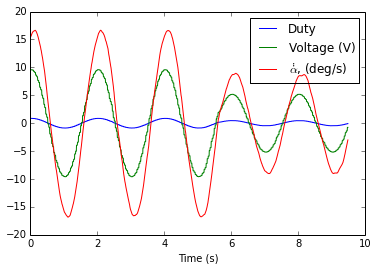

In [156]:
with open('data/segway/log_sysid_motor/sess001/log001.csv', 'r') as loadfile:
    motor_data = px4_logutil.px4_log_to_namedtuple(loadfile)
    
data = handle_log_data_motors(motor_data, 12500, 14000)
pl.plot(data.t, data.duty)
pl.plot(data.t, data.V)
pl.plot(data.t, data.alphadot)
pl.xlabel('Time (s)')
pl.legend(['Duty','Voltage (V)', r'$\dot\dot{\alpha}$, (deg/s)'], loc='best')
#pl.xlim([0, 50])

## Least Squares Analysis 

In [157]:
delay = 0
A = np.vstack((-data.alphadot, np.roll(data.V, delay))).T #now column 1 is thetadot, column 2 is thetaddot
b = data.alphaddot
b_damp_over_Jm, k_emf_over_Jm = np.dot(pl.pinv(A), b) #x = A+ dot b (solution to Ax=b)
b_damp_over_Jm, k_emf_over_Jm

(13.3710168101, 23.785596363)

## Simulation and Validation

In [158]:
def motor_eom(t, x, b_damp_over_J, k_emf_over_J, V): #x is a vector of states [alpha; alphadot]
    alpha = x[0]
    alpha_dot = x[1]
    rhs = V*k_emf_over_J - b_damp_over_J*alpha_dot #rhs of the equation of motion for theta
    return [alpha_dot, rhs]

In [162]:
def simulate_motor(b_damp_over_J, k_emf_over_J, delay, data, plot):
    V_delay = np.roll(data.V, delay)
    sim = scipy.integrate.ode(motor_eom) #setup for ode intergration
    sim.set_initial_value(y = [ data.alpha[0], data.alphadot[0] ], t = data.t[0]) #set initial values
    i = 0
    x = np.zeros((len(data.t), 2)) #define array to hold calculated values from integration
    x[0,:] = sim.y
    for i in range(1,len(data.t)): #step through time vector and integrate the states
        sim.set_f_params(b_damp_over_J, k_emf_over_J, V_delay[i]) #pass other variables in the integration
        sim.integrate(data.t[i])
        x[i,:] = sim.y
    alphadot_sim = x[:,1]
    if plot: #plot the results against the expected
        pl.plot(data.t, pl.rad2deg(data.alphadot).max(0)*data.duty/data.duty.max(0), '-')
        pl.plot(data.t, pl.rad2deg(data.alphadot))
        pl.plot(data.t, pl.rad2deg(x[:,1]))
        pl.xlabel('Time (s)')
        pl.ylabel(r'$\dot\dot{\alpha}$, (deg/s)')
        pl.legend(['Scaled Duty Cycle','Experimental','Simulated'], loc='best')
        pl.ylim([-1400, 2100])
    return alphadot_sim

### Trial 1 Data Validation

0.999443389547

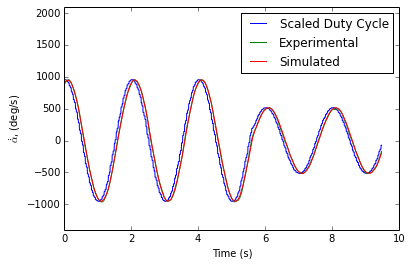

In [164]:
trial1 = handle_log_data_motors(motor_data, 12500, 14000)
alphadot_sim1 = simulate_motor(b_damp_over_Jm, k_emf_over_Jm, delay, trial1, True)
R_squared(trial1.alphadot, alphadot_sim1) #calculate R^2

### Trial 2 Data Validation

0.974354585855

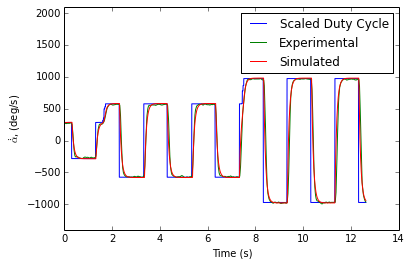

In [165]:
trial2 = handle_log_data_motors(motor_data, 10000, 12000)
alphadot_sim2 = simulate_motor(b_damp_over_Jm, k_emf_over_Jm, delay, trial2, True)
R_squared(trial2.alphadot, alphadot_sim2) #calculate R^2

### Trial 3 Data Validation

0.990022257218

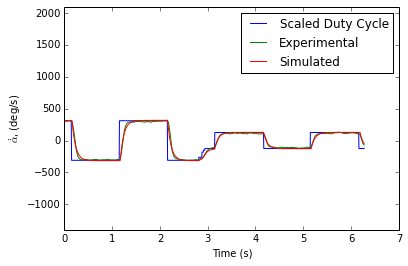

In [172]:
trial3 = handle_log_data_motors(motor_data, 17000, 18000)
alphadot_sim3 = simulate_motor(b_damp_over_Jm, k_emf_over_Jm, delay, trial3, True)
R_squared(trial3.alphadot, alphadot_sim3) #calculate R^2

#System Identification - Motor + Wheel Experiment

The third experiment is almost identical to the second, except now the wheels are now attached.  This means that the MOI of the wheel must also be included in the dynamics.

In [173]:
eom_motor_wheel = eom_motor.subs({J_motor:(J_w + J_motor)}) \
    #the wheels are still attached, so need to include wheel MOI

In [174]:
motor_sysID_wheel = eom_motor_wheel.subs({T(t):0}) #no external torque is being applied
motor_sysID_wheel

                                                   2      
         d                                        d       
- b_damp⋅──(α(t)) + k_emf⋅V(t) - (J_motor + J_w)⋅───(α(t))
         dt                                        2      
                                                 dt       

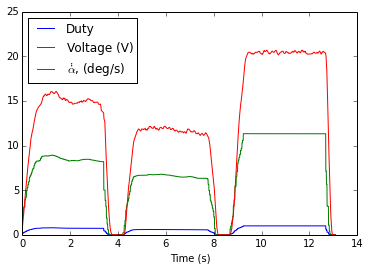

In [175]:
with open('data/segway/motor_sysid/sess001/log001.csv', 'r') as loadfile:
    motor_data1 = px4_logutil.px4_log_to_namedtuple(loadfile)
    
trial1 = handle_log_data_motors(motor_data1, 500, 2550)
pl.plot(trial1.t, trial1.duty)
pl.plot(trial1.t, trial1.V)
pl.plot(trial1.t, trial1.alphadot)
pl.xlabel('Time (s)')
pl.legend(['Duty','Voltage (V)', r'$\dot\dot{\alpha}$, (deg/s)'], loc='best')

##Least Squares Analysis 

In [176]:
delay = 0
A = np.vstack((-trial1.alphadot, np.roll(trial1.V, delay))).T #now column 1 is thetadot, column 2 is thetaddot
b = trial1.alphaddot
b_damp_over_Jm, k_emf_over_Jm = np.dot(pl.pinv(A), b) #x = A+ dot b (solution to Ax=b)
b_damp_over_Jm, k_emf_over_Jm

(11.854139859, 21.2902691382)

## Simulation and Validation

### Trial 1 Data Validation

0.996699254146

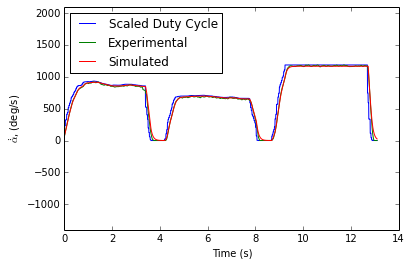

In [177]:
alphadot_sim1 = simulate_motor(b_damp_over_Jm, k_emf_over_Jm, delay, trial1, True)
R_squared(trial1.alphadot, alphadot_sim1) #calculate R^2

### Trial 2 Data Validation

0.996993438815

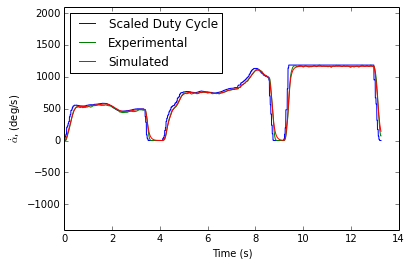

In [178]:
with open('data/segway/motor_sysid/sess002/log001.csv', 'r') as loadfile:
    motor_data2 = px4_logutil.px4_log_to_namedtuple(loadfile)
    
trial2 = handle_log_data_motors(motor_data2, 500, 2600)
alphadot_sim2 = simulate_motor(b_damp_over_Jm, k_emf_over_Jm, delay, trial2, True)
R_squared(trial2.alphadot, alphadot_sim2) #calculate R^2

### Trial 3 Data Validation

0.997717135241

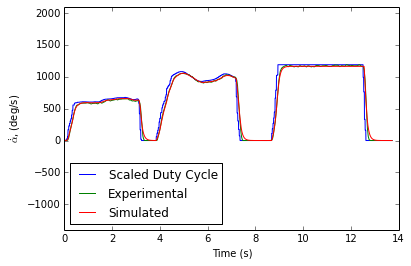

In [179]:
with open('data/segway/motor_sysid/sess003/log001.csv', 'r') as loadfile:
    motor_data3 = px4_logutil.px4_log_to_namedtuple(loadfile)
    
trial3 = handle_log_data_motors(motor_data3, 450, 2600)
alphadot_sim3 = simulate_motor(b_damp_over_Jm, k_emf_over_Jm, delay, trial3, True)
R_squared(trial3.alphadot, alphadot_sim3) #calculate R^2

# Results

From these experiments, certain parameters or ratios were able to be determined.

Pendulum Experiment: $b_{damp,p} = 0.1249$
$J_{total} = 0.4717$

Motor Experiment: $\frac{b_{damp,m}}{J_{motor}} = 13.3710$
$\frac{k_{emf}}{J_{motor}} = 23.7856$

Motor + Wheel Experiment: $\frac{b_{damp,m}}{J_w + J_{motor}} = 11.8541$
$\frac{k_{emf}}{J_w + J_{motor}} = 21.2903$


# Determining Parameters Through Motor Specification Analysis

The equations of motion for a DC Motor are given below: (http://mplab.ucsd.edu/tutorials/dc.pdf)

$V(t) = L\dot{I(t)} + RI + k_b\dot{\alpha}$

$J\ddot{\alpha} = k_{\tau}I(t) - \nu\dot{\alpha} - \tau$

where $V$ is voltage, $L$ is motor inductance, $I$ is current, $R$ is motor winding resistance, $\dot{\alpha}$ is the rotor's angular velocity, $k_b$ is the back emf constant, $k_{\tau}$ is the motor's torque constant, $\nu$ is the motor's viscous friction constant, and $\tau$ is the external torque applied to the rotor.  Note that the second equation above is very similar to the equation of motion for the motor that we had derived earlier.  Lets rewrite the two equations above to create a new equation with the same form as what we had earlier.  This yields:

$J\ddot{\alpha}  + (\nu + \frac{k_{\tau}k_b}{R})\dot{\alpha} - \frac{k_{\tau}}{R}V(t)$

and the original equation was:

$J\ddot{\alpha} + {b_{damp,m}} \dot{\alpha} - {k_{emf}} V(t) = 0$

so we can now write:

$b_{damp,m} = \nu + \frac{k_{\tau}k_b}{R}$

$k_{emf} = \frac{k_{\tau}}{R}$
 
The values $R$, $k_{\tau}$, $k_{b}$, and $\nu$ can be calculated from given specificiations of the motor by performing an equilibrium analysis on the equations given above.  This is detailed in http://mplab.ucsd.edu/tutorials/dc.pdf.  The motor specifications are:

No Load Current: $I_{nl} = 0.3 A$

Stall Current: $I_{s} = 5 A$

No Load Voltage: $V_{nl} = 12 V$

Stall Voltage: $V_{s} = 12 V$

No Load Rotational Speed: $\omega_{nl} = 200$ $rpm = 20.943951$ $rad/s$

Stall Torque: $\tau_{s} = 170$ $oz$-$in = 1.2$ $N$-$m$

From the equilibrium analysis, the values can be found using the following relations:

$R = \frac{V_s}{I_s} = 2.4$

$k_{\tau} = \frac{\tau_s}{I_s} = 0.24$

$k_{b} = \frac{1}{I_s\omega_{nl}}(-I_{nl}V_s + I_sV_{nl}) = 0.5386$

$\nu = \frac{I_{nl}\tau_s}{I_s\omega_{nl}} = 0.003438$

From these results, we can then find:

$b_{damp,m} = 0.057296$ (the damping from 1 motor)

$k_{emf} = 0.1$ (the voltage to torque gain of 1 motor)

$J_{motor} = 0.004245$ $kg$-$m^2$ (note this is for only 1 motor)

$J_w + J_{motor} = 0.004765$ $kg$-$m^2$ (note this is for only 1 wheel + 1 motor)

Note that $b_{damp,m}$ computed using the motor specifications is about half of what was predicted using the system identification analysis from the pendulum experiment.  This is due to the fact that $b_{damp,p}$ from the pendulum experiment includes two motors, where the motor analysis only accounts for one.  Additionally, aerodynamic drag and other damping effects play a role in a slightly higher value.  The $b_{damp,p}$ from the pendulum experiment is more accurate for use in the final equations.  Now putting all of this together:



$b_{damp} = 0.124919434429$

$k_{emf} = 0.2$

$J_{motor} = 0.004765$ $kg$-$m^2$

$J_{w} = 0.00052$ $kg$-$m^2$

$J_{p} = 0.236063$ $kg$-$m^2$

# Conclusions

We have now determined all of the unknown parameters that are present in the non-linear equations of motion for the segway.  This is an important step because it enables us to now perform the controls analysis of the system.  Our next steps will be to linearize the equations of motion about the operating conditions, and the develop the state space system and substitute these parameters into the system.  Then we will be able to design a controller using pole placement or LQR techniques.